# Prosper Loan Data
## by Nidhi Mishra

## Investigation Overview

The main agenda of this presentation is to introduce the key features of an Loan and other not-so known factors that affect the primary features. Further to show how these factors are inter-dependent.

## Dataset Overview

This dataset about the various variables and factors related to a Loan taken. It has 113937 entries with 81 features, including features of primary importance including loan Term, Loan Amount, Interest Rate, MonthlyIncome, etc.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loanData = pd.read_csv('ProsperLoanData.csv')

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

In [3]:
loanData = loanData[loanData.EmploymentStatus != 'Not available']

# Taking Average of Upper and Lower Credit Score
loanData['CreditScore'] = loanData['CreditScoreRangeLower'] + loanData['CreditScoreRangeUpper']/2

# Split variable LoanOriginationQuarter
loanData['LoanOriginQuarter'], loanData['LoanOriginYear'] = loanData['LoanOriginationQuarter'].str.split(" ", 1).str
loanData.drop(columns =["LoanOriginationQuarter"], inplace = True)

# Keeping the only required variables
A = ['Term', 'LoanStatus', 'BorrowerRate', 'ListingCategory (numeric)', 'StatedMonthlyIncome', 'OpenRevolvingMonthlyPayment', 'BorrowerState', 'EmploymentStatus', 'IsBorrowerHomeowner', 'CreditScore', 'DebtToIncomeRatio', 'IncomeRange',
     'LoanOriginalAmount', 'LoanOriginQuarter', 'CurrentCreditLines', 'AvailableBankcardCredit', 'BankcardUtilization', 'CurrentDelinquencies', 'MonthlyLoanPayment', 'InquiriesLast6Months', 'LoanOriginYear']
loanData = loanData[A]

In [4]:
# convert categorical data into ordered categorical types
ordinal_var_dict = {'Term': [12, 36, 60],
                    'LoanStatus': ['Current', 'Completed', 'Chargedoff', 'Defaulted', 'Past Due (1-15 days)', 'Past Due (31-60 days)', 
                                   'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (16-30 days)', 'FinalPaymentInProgress',
                                  'Past Due (>120 days)', 'Cancelled'],
                   'IncomeRange': ['$25,000-49,999', '$50,000-74,999', '$100,000+', '$75,000-99,999', 'Not displayed','$1-24,999','Not employed','$0'],
                   'LoanOriginQuarter': ['Q1', 'Q2', 'Q3', 'Q4'],
                'ListingCategory (numeric)': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                   'EmploymentStatus': ['Employed', 'Full-time', 'Self-employed', 'Other','Part-time', 'Not employed', 'Retired']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loanData[var] = loanData[var].astype(ordered_var)
loanData = loanData.dropna()

## Distribution of Interest Rate

The first term that comes to mind has to Interest rate. We found that the average interest rate charged is 18% as seen below:

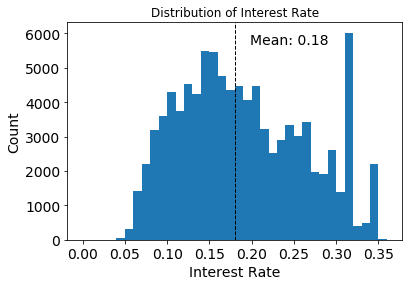

In [5]:
bins = np.arange(0, loanData['BorrowerRate'].max()+ 0.01, 0.01)
plt.hist(data = loanData, x = 'BorrowerRate', bins = bins);
plt.xticks(fontsize =14);
plt.yticks(fontsize =14);
plt.axvline(bins.mean(), color='k', linestyle='dashed', linewidth=1)

#Getting mean of the data to plot vertical line
_, max_ = plt.ylim()
plt.text(bins.mean() + bins.mean()/10, 
         max_ - max_/10, 
         'Mean: {:.2f}'.format(bins.mean()), size = 14)
plt.xlabel('Interest Rate', fontsize = 14);
plt.ylabel('Count', fontsize = 14);
plt.title('Distribution of Interest Rate');

## Distribution of various Loan puposes :

Over 50% of loan is taken for Debt consolidation! Quite unexpected.

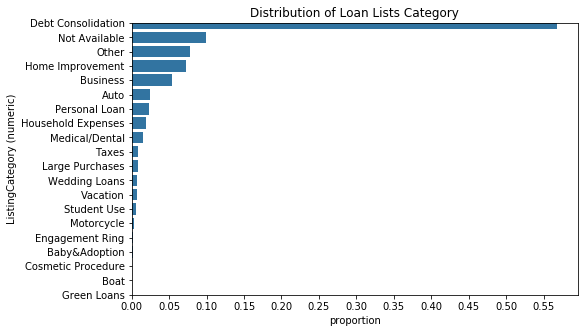

In [6]:
# get proportion taken by most common group for derivation of tick marks
list_order =loanData['ListingCategory (numeric)'].value_counts().index
n_points = loanData.shape[0]
max_count = loanData['ListingCategory (numeric)'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
plt.figure(figsize=[8, 5])

# create the plot
sb.countplot(data = loanData, y = 'ListingCategory (numeric)', color = sb.color_palette()[0], order = list_order);
labels = ['Debt Consolidation', 'Not Available', 'Other', 'Home Improvement',  'Business', 'Auto', 'Personal Loan', 'Household Expenses', 'Medical/Dental', 'Taxes', 'Large Purchases','Wedding Loans',
          'Vacation', 'Student Use', 'Motorcycle', 'Engagement Ring', 'Baby&Adoption', 'Cosmetic Procedure', 'Boat', 'Green Loans', 'RV']
plt.yticks(np.arange(20),labels);
plt.xticks(tick_props * n_points, tick_names);
plt.xlabel('Proportion');
plt.title('Distribution of Loan Lists Category');

## Distribution of Credit score:

The Credit score has a normal distribution, peaked at 1000, which means maximum people get a 1000 score. Which is pretty good. 

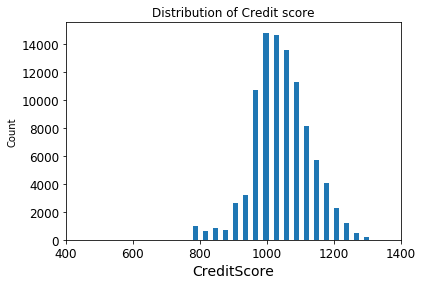

In [19]:
bins = np.arange(0, loanData['CreditScore'].max() +15, 15)
plt.hist(data = loanData, x = 'CreditScore', bins = bins);
plt.xlim(400, 1400);
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('CreditScore', fontsize = 14);
plt.ylabel('Count');
plt.title('Distribution of Credit score');

In [8]:
#For LoanStatus lets use a binomial model, so we can label the loans that are either “Completed” or “Current” with a ‘1’ and rest as ‘0’. 
#For easier plotting, Lets create a function to do this.

def label_loan (row):
   if row['LoanStatus'] == "Cancelled" :
      return 0
   if row['LoanStatus'] == "Chargedoff" :
      return 0
   if row['LoanStatus'] == "Chargedoff" :
      return 0
   if row['LoanStatus'] == "Past Due (1-15 days)" :
      return 0
   if row['LoanStatus'] == "Past Due (61-90 days)":
      return 0
   if row['LoanStatus'] == "Past Due (31-60 days)":
      return 0
   if row['LoanStatus'] == "Past Due (91-120 days)":
      return 0
   if row['LoanStatus'] == "Past Due (16-30 days)":
      return 0
   if row['LoanStatus'] == "Past Due (> 120 days)":
      return 0
   if row['LoanStatus'] == "FinalPaymentInProgress":
      return 0
   else:
        return 1

#Applying the function to the dataframe
loanData['LoanValue'] = loanData.apply(lambda row: label_loan(row), axis=1)
loanData['LoanValue'].value_counts()

1    85132
0    11055
Name: LoanValue, dtype: int64

## A plot of Income Range v/s Loan Status

Loan status is a major role player in loan as expected. We can see that Non-Defaulters with an average income range in 25K - 75K have received the maximum loans.

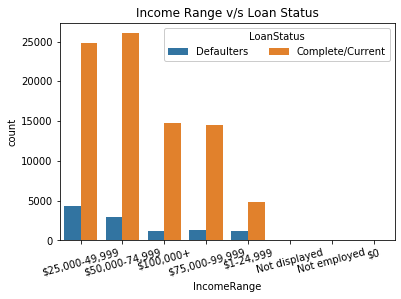

In [9]:
income_order = loanData['IncomeRange'].value_counts().index
ax = sb.countplot(data = loanData, x = 'IncomeRange', hue = 'LoanValue', order = income_order);
ax.legend(labels = ['Defaulters', 'Complete/Current'], loc = 1, ncol = 2, framealpha = 1, title = 'LoanStatus');
plt.xticks(rotation = 15);
plt.title("Income Range v/s Loan Status");

## A plot of Current Delinquencies v/s Credit Score
 
From below plot, it is evident that lesser Current delinquencies guarantees higher Credit score.

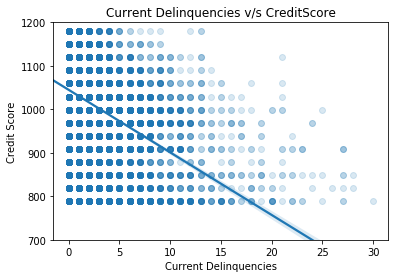

In [10]:
# Remoivng outliers from both variables
loan1 = loanData[(loanData['CreditScore'] <= 1200) & (loanData['CurrentDelinquencies'] <= 30) ]
#Plotting:
sb.regplot(loan1['CurrentDelinquencies'], loan1['CreditScore'], scatter_kws = {'alpha' : 1/6});
plt.xlabel("Current Delinquencies");
plt.ylabel("Credit Score");
plt.title("Current Delinquencies v/s CreditScore");
plt.ylim(700, 1200);

## A plot of Employment status and term
Here we find that employed people tend to get max loans for an average period of 3 years.

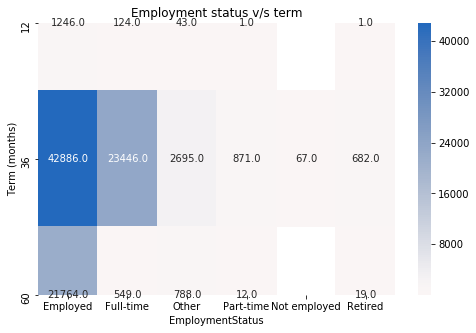

In [18]:
# Summarizing the counts into a matrix that will be used to plot.
et_counts = loanData.groupby(['EmploymentStatus', 'Term']).size()
et_counts = et_counts.reset_index(name ='counts')
et_counts = et_counts[(et_counts.EmploymentStatus == 'Employed') | (et_counts.EmploymentStatus == 'Full-time')| (et_counts.EmploymentStatus == 'Other')| (et_counts.EmploymentStatus == 'Part-time')| 
                      (et_counts.EmploymentStatus == 'Not employed')| (et_counts.EmploymentStatus == 'Retired')]
et_counts = et_counts.pivot(index = 'Term', columns ='EmploymentStatus', values ='counts')

#Plotting:
plt.figure(figsize = [8, 5])
sb.heatmap(et_counts, annot=True, fmt ='.1f', cmap = 'vlag_r', center = 0);
plt.title("Employment status v/s term");
plt.ylabel("Term (months)");

## Matrix Plot between Loan Amount, CreditScore, BorrowerRate:

There are few interesting features that we can see from this plot,

- Interest rate and credit score tend to inversely related. 

- We can see that interest tend be lesser for higher loan amounts.

- Credit Score is higher for higher loan amounts.

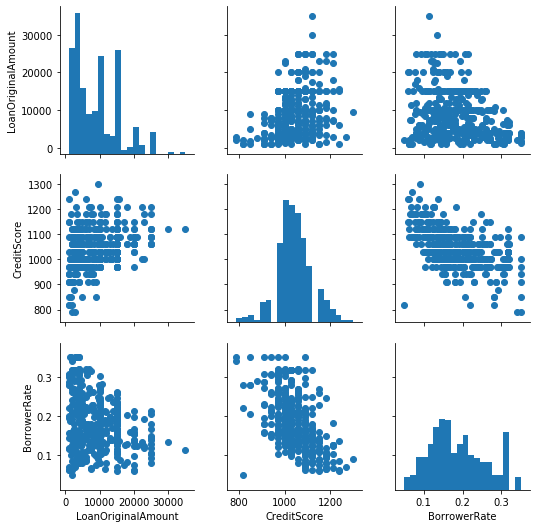

In [42]:
# plot matrix: sample 500 loan data so that plots are clearer and
# they render faster
numeric_vars = ['LoanOriginalAmount', 'CreditScore', 'BorrowerRate']

samples = np.random.choice(loanData.shape[0], 500, replace = False);
loanData_samp = loanData.loc[samples,:]

g = sb.PairGrid(data = loanData_samp, vars = numeric_vars);
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

## Matrix Plot between Loan Amount, MonthlyIncome, DebtToIncomeRatio:

There are few interesting features that we can see from this plot,

- Most of current Delinquencies are between 0 - 1 across all features indicating a higher ratio is not accepted.
- Monthly income is higher for higher loan amounts

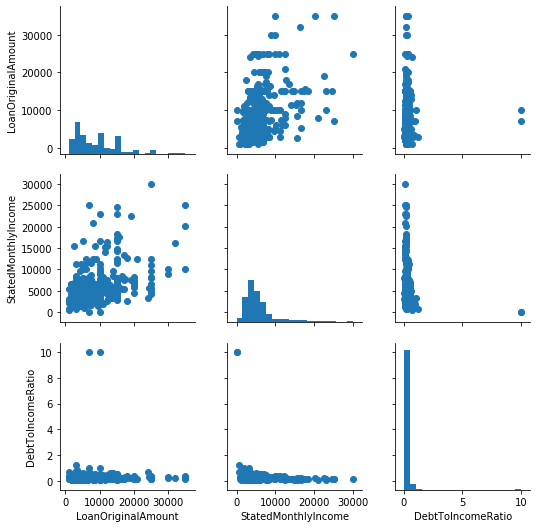

In [43]:
# plot matrix: sample 500 loan data so that plots are clearer and
# they render faster
numeric_vars = ['LoanOriginalAmount', 'StatedMonthlyIncome', 'DebtToIncomeRatio']

samples = np.random.choice(loanData.shape[0], 500, replace = False);
loanData_samp = loanData.loc[samples,:]

g = sb.PairGrid(data = loanData_samp, vars = numeric_vars);
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

## A plot of LoanOriginalAmount v/s Term v/s IncomeRange:
Here we see that applicants under largest income bracket have taken the largest loan amounts and longest loan term of 5 years. This new as the mean term is 3 years, here we get more insight that larger the loan amount, longer the term of loan.

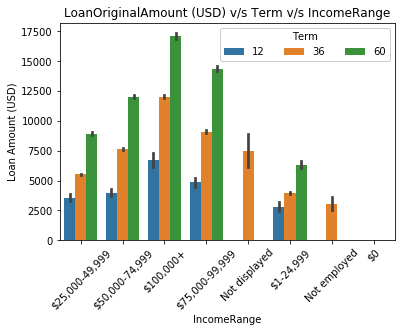

In [16]:
ax = sb.barplot(data = loanData, x = 'IncomeRange', y = 'LoanOriginalAmount', hue = 'Term');
ax.legend(loc = 1, ncol = 3, framealpha = 1, title = 'Term');
plt.xticks(rotation = 45);
plt.title('LoanOriginalAmount (USD) v/s Term v/s IncomeRange');
plt.ylabel('Loan Amount (USD)');

## A plot of Current Credit Lines v/s Credit Score v/s Bankcard Utilization:

Here as well we see a inverse relation between Credit utilization and credit Lines . We can again see that credit score is lower for higher credit utilization. So we can establish that there is direct relation between credit lines and credit score.

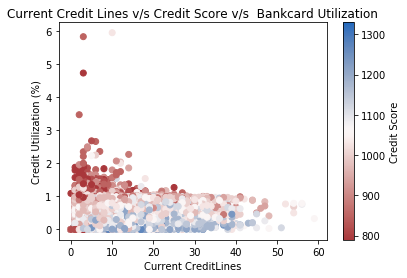

In [17]:
plt.scatter(data = loanData, x = 'CurrentCreditLines', y = 'BankcardUtilization', c = 'CreditScore', cmap ='vlag_r');
plt.colorbar(label = 'Credit Score');
plt.xlabel('Current CreditLines');
plt.ylabel('Credit Utilization (%)');
plt.title('Current Credit Lines v/s Credit Score v/s  Bankcard Utilization');

## A plot of Debt-To-Income Ratio v/s Interest Rate v/s isHomeOwner:

Here we see that although most of loan falls under lowest Debt-to-income ratio, the interest seems to be incresing to incresing Debt-to-income ratio. However we can have an egde over non-home owners even if we have higher debt-to-income ratio.

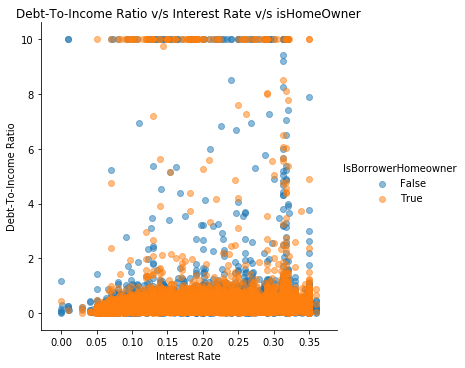

In [15]:
g = sb.FacetGrid(data = loanData, hue = 'IsBorrowerHomeowner', height = 5)
g.map(sb.regplot, 'BorrowerRate', 'DebtToIncomeRatio', fit_reg = False, scatter_kws = {'alpha' : 1/2});
g.add_legend();
plt.xlabel('Interest Rate');
plt.ylabel('Debt-To-Income Ratio');
plt.title('Debt-To-Income Ratio v/s Interest Rate v/s isHomeOwner');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

## Thank You!